In [1]:
'''
Change from torchvision: https://github.com/pytorch/vision
Used for both image and target transforms
'''


import math
import random
import numbers
import numpy as np
from PIL import Image, ImageOps
import collections

In [2]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, img, mask):
        assert img.size == mask.size
        for t in transforms:
            img, mask = t(img, mask)
        return img, mask

In [3]:
class Resize(object):
    def __init__(self, size):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        
    def __call__(self, img, mask):
        assert img.size == mask.size
        if isinstance(self.size, int):
            w, h = img.size
            if (w <= h and w == self.size) or (h <= w and h == self.size):
                return img, mask
            if w < h:
                ow = self.size
                oh = int(self.size * h / w)
                return img.resize((ow, oh), Image.BILINEAR), mask.resize((ow, oh), Image.NEAREST)
            else:
                oh = self.size
                ow = int(self.size * w / h)
                return img.resize((ow, oh), Image.BILINEAR), mask.resize((ow, oh), Image.NEAREST)
        else:
            return img.resize(self.size[::-1], Image.BILINEAR), mask.resize(self.size[::-1], Image.NEAREST)

In [4]:
class CenterCrop(object):
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        
    def __call__(self, img, mask):
        assert img.size == mask.size
        w, h = img.size
        th, tw = self.size
        i = int(round((h - th) / 2.))
        j = int(round((w - tw) / 2.))
        return img.crop((j, i, j + tw, i + th)), mask.crop((j, i, j + tw, i + th))

In [5]:
class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        
    def __call__(self, img, mask):
        assert img.size == mask.size
        if self.padding > 0:
            img = ImageOps.expand(img, border=self.padding, fill=0)
            mask = ImageOps.expand(mask, border=self.padding, fill=0)
            
        w, h = img.size
        th, tw = self.size
        if w == tw and h == th:
            return img, mask

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return img.crop((j, i, j + tw, i + th)), mask.crop((j, i, j + tw, i + th))

In [6]:
class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, img, mask):
        assert img.size == mask.size
        if random.random() < self.p:
            return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
        else:
            return img, mask

In [7]:
class RandomVerticalFlip(object):
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, img, mask):
        assert img.size == mask.size
        if random.random() < self.p:
            return img.transpose(Image.FLIP_TOP_BOTTOM), mask.transpose(Image.FLIP_TOP_BOTTOM)
        else:
            return img, mask

In [8]:
class RandomResizedCrop(object):
    def __init__(self, size, scale=(0.08, 1.0), ratio=(3. / 4, 4. / 3)):
        self.size = (size, size)
        self.scale = scale
        self.ratio = ratio
        
    def __call__(self, img, mask):
        assert img.size == mask.size
        for attempt in range(10):
            area = img.size[0] * img.size[1]
            target_area = random.uniform(*self.scale) * area
            aspect_ratio = random.uniform(*self.ratio)
            
            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))
            
            if random.random() < 0.5:
                w, h = h, w
            
            if w <= img.size[0] and h <= img.size[1]:
                i = random.randint(0, img.size[1] - h)
                j = random.randint(0, img.size[0] - w)
                
                img = img.crop((j ,i, j + w, i + h))
                mask = mask.crop((j, i, j + w, i + h))
                
                return img.resize(self.size, Image.BILINEAR), mask.resize(self.size, Image.NEAREST)
            
        # Fallback
        resize = Resize(self.size)
        crop = CenterCrop(self.size)
        return crop(*resize(img, mask))

In [9]:
class ColorJitter(object):
    pass

In [10]:
class RandomRotation(object):
    def __init__(self, degrees, resample=True, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            self.degrees = (-degrees, degrees) if degrees < 0 else (degrees, -degrees)
        else:
            self.degrees = degrees
            
        self.resample = resample
        self.expand = expand
        self.center = center
        
    def __call__(self, img, mask):
        assert img.size == mask.size
        angle = np.random.uniform(self.degrees[0], self.degrees[1])
        if self.resample:
            return img.rotate(angle, Image.BILINEAR, self.expand, self.center), \
                    mask.rotate(angle, Image.NEAREST, self.expand, self.center)
        else:
            return img.rotate(angle, self.resample, self.expand, self.center), \
                    mask.rotate(angle, self.resample, self.expand, self.center)
        

In [11]:
# Test
import matplotlib.pyplot as plt
img = Image.open('./data/img.jpg')
mask = Image.open('./data/mask.png')
def plotImgMask(img, mask):
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.show()
print(img.size, img.mode, mask.size, mask.mode)

(500, 375) RGB (500, 375) P


In [12]:
# transform = Resize(200)
# plotImgMask(*transform(img, mask))
# transform = Resize((800,800))
# plotImgMask(*transform(img, mask))

In [13]:
# transform = CenterCrop(200)
# plotImgMask(*transform(img, mask))
# transform = CenterCrop((300,300))
# plotImgMask(*transform(img, mask))

In [14]:
# transform = RandomCrop(200)
# plotImgMask(*transform(img, mask))
# transform = RandomCrop((300,300), padding=100)
# plotImgMask(*transform(img, mask))

In [15]:
# transform = RandomHorizontalFlip(p=0.8)
# plotImgMask(*transform(img, mask))
# transform = RandomVerticalFlip(p=0.8)
# plotImgMask(*transform(img, mask))

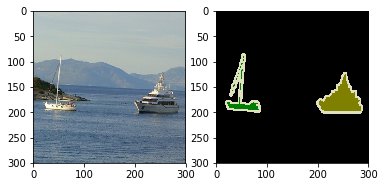

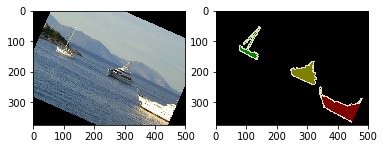

In [20]:
transform = RandomResizedCrop(300)
plotImgMask(*transform(img, mask))
transform = RandomRotation(45)
plotImgMask(*transform(img, mask))